In [7]:
pip install CoolProp

     |████████████████████████████████| 2.6 MB 5.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import math 
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI

In [9]:
def TC(T):
 # converts K to C
    TC = T - 273.15
    return TC

In [10]:
def TK(T):
 # converts C to K
    TK = T + 273.15
    return TK

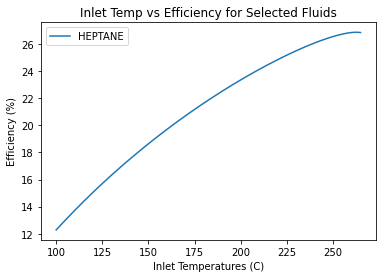

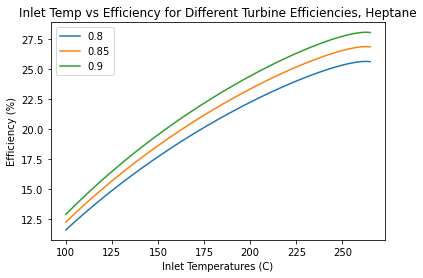

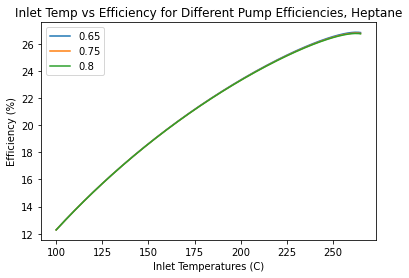

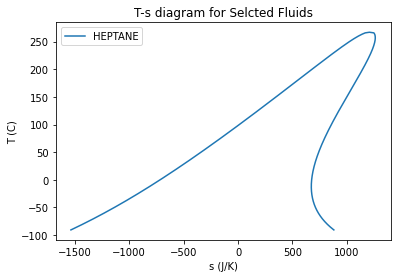

the efficiency for HEPTANE is 21.023065484689003 percent
pump work:  0.7178420785737107  kJ/kg
turbine work:  113.2533976222357  kJ/kg
Temperatures (1 to 6 in order):  185 120.50734119267679 70.88361869694847 35 35.0198717529787 76.34994911781149
Pressures (1 to 6 in order):  751221.839391539 9835.30906291762 9835.30906291762 9835.30906291762 751221.839391539 751221.839391539
Entropies (1 to 6 in order):  1101.6712756707632 1174.8823145582915 910.0205506061429 -450.5466904878718 -451.800622201483 -154.6269129885933
Change in Entropies:  73.21103888752828 -264.8617639521485 -1360.5672410940147 -1.2539317136112231 297.1737092128897 1256.2981886593566
the efficiency for HEPTANE is 22.079618380369116 percent
pump work:  0.7178420785737107  kJ/kg
turbine work:  120.33173497362546  kJ/kg
Temperatures (1 to 6 in order):  185 117.088433909983 70.54172796867914 35 35.0198717529787 73.71629792759427
Pressures (1 to 6 in order):  751221.839391539 9835.309062917615 9835.309062917615 9835.309062917

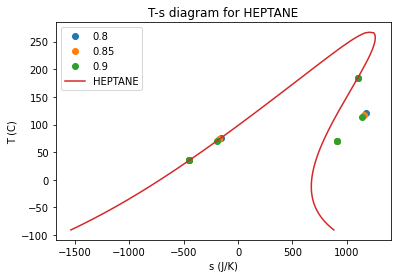

In [80]:
# find temp levels for different DNI parabolic troughs
# driver Function
T1 = 185 #temp into the turbine estimate in C
T4 = 35 #temp out of condenser also an estimate in C
#'TOLUENE','NOCTANE','CYCLOPENTANE','BENZENE' BUTANE
Fluids = ['HEPTANE']
nt = [0.8,0.85,0.9]
np = [0.65,0.75,0.8]

plt.figure()
for F in Fluids:
    inlet_temperatures, efficiencies = efficiencyPlot(F,0.85,0.65) # default values from Kashif paper
    plt.plot(inlet_temperatures, efficiencies,label=F)
plt.xlabel("Inlet Temperatures (C)")
plt.ylabel("Efficiency (%)")
plt.title('Inlet Temp vs Efficiency for Selected Fluids')
plt.legend()
plt.show()

plt.figure()
for n in nt:
    inlet_temperatures, efficiencies = efficiencyPlot('HEPTANE',n,0.65)
    plt.plot(inlet_temperatures, efficiencies,label=n)
plt.xlabel("Inlet Temperatures (C)")
plt.ylabel("Efficiency (%)")
plt.title('Inlet Temp vs Efficiency for Different Turbine Efficiencies, Heptane')
plt.legend()
plt.show()

plt.figure()
for n in np:
    inlet_temperatures, efficiencies = efficiencyPlot('HEPTANE',0.85,n)
    plt.plot(inlet_temperatures, efficiencies,label=n)
plt.xlabel("Inlet Temperatures (C)")
plt.ylabel("Efficiency (%)")
plt.title('Inlet Temp vs Efficiency for Different Pump Efficiencies, Heptane')
plt.legend()
plt.show()

plt.figure()
for F in Fluids:
    T_vals, s_vals, combined_temps, combined_entropies = runCycle(T1,T4,F,False,0.85,0.65)
    plt.plot(combined_entropies, combined_temps,label=F)
plt.xlabel("s (J/K)")
plt.ylabel("T (C)")
plt.title('T-s diagram for Selcted Fluids')
plt.legend()
plt.show()

for F in Fluids:
    for n in nt:
        T_vals, s_vals, combined_temps, combined_entropies = runCycle(T1,T4,F,True,n,0.65)
        plt.plot(s_vals, T_vals,'o',label=n)
    plt.plot(combined_entropies, combined_temps,label=F)
    plt.xlabel("s (J/K)")
    plt.ylabel("T (C)")
    plt.title('T-s diagram for '+F)
    plt.legend()
    plt.show()

In [66]:
def efficiencyPlot(F,nt,np):
    # efficiencies and inlet temperature relation for this selected fluid
    inlet_temperatures = []
    efficiencies = []
    highT = math.floor(TC(PropsSI('Tcrit', F)))
    
    for T1 in range(100,highT):
        inlet_temperatures.append(T1)
        P1 = PropsSI('P','T|gas',TK(T1),'Q',1, F)#saturated vapor for a dry fluid, units Pa
        s1 = PropsSI('S','T|gas',TK(T1),'P',P1, F)
        h1 = PropsSI('H','T|gas',TK(T1),'P',P1, F)
    
        # THROUGH CONDENSER
        T4 = 35 #also an estimate in C
        P4 = PropsSI('P','T|liquid',TK(T4),'Q',0, F)
        s4 = PropsSI('S','T|liquid',TK(T4),'P',P4, F)
        h4 = PropsSI('H','T|liquid',TK(T4),'P',P4, F)
    
        # THROUGH TURBINE
        P2 = P4
        h2s = PropsSI('H','P',P2,'S',s1, F)
        h2a = h1-nt*(h1-h2s)
        s2 = PropsSI('S','H',h2a,'P',P2, F)
        T2 = PropsSI('T','P',P2,'S',s2, F)
    
        # THROUGH PUMP
        P5 = P1
        h5s = PropsSI('H','P',P5,'S',s4, F)
        h5a = h4-np*(h4-h5s)
        T5 = PropsSI('T','P',P5,'H',h5a, F)
        s5 = PropsSI('S','T|liquid',T5,'P',P5, F)
    
        # THROUGH HXGR
        e = 0.9 #hxgr effectiveness, an estimate given by previous research
        P3 = P2
        P6 = P5
        T3 = TK(T2) - e*(TK(T2)-T5)
        h3 = PropsSI('H','P',P3,'T',T3, F)
        h6 = h2a-h3+h5a
        T6 = PropsSI('T','H',h6,'P',P6, F)
        s3 = PropsSI('S','T',T3,'P',P3, F)
        s6 = PropsSI('S','T',T6,'P',P6, F)
    
        #efficiency calculation
        wdot_t = h1-h2a
        wdot_p = h5a-h4
        q_h = h1-h6
        q_c = h3-h4
        eta = 100*(-wdot_t+wdot_p)/-q_h
        efficiencies.append(eta)

    return inlet_temperatures, efficiencies

In [76]:
def runCycle(T1,T4,F,T,nt,np):
    CP.set_reference_state(F,'NBP')
    #define proper input parameters, give reasonable estimates for temp out of boiler
    #print('GWP100 is ', PropsSI(F,'GWP100'), 'ODP is ', PropsSI(F,'ODP'))
    P1 = PropsSI('P','T|gas',TK(T1),'Q',1, F)#saturated vapor for a dry fluid, units Pa
    s1 = PropsSI('S','T|gas',TK(T1),'P',P1, F)
    h1 = PropsSI('H','T|gas',TK(T1),'P',P1, F)
    
    # THROUGH CONDENSER
    P4 = PropsSI('P','T|liquid',TK(T4),'Q',0, F)
    s4 = PropsSI('S','T|liquid',TK(T4),'P',P4, F)
    h4 = PropsSI('H','T|liquid',TK(T4),'P',P4, F)
    
    # THROUGH TURBINE
    P2 = P4
    h2s = PropsSI('H','P',P2,'S',s1, F)
    h2a = h1-nt*(h1-h2s)
    s2 = PropsSI('S','H',h2a,'P',P2, F)
    T2 = PropsSI('T','P',P2,'S',s2, F)
    
    # THROUGH PUMP
    P5 = P1
    h5s = PropsSI('H','P',P5,'S',s4, F)
    h5a = h4-np*(h4-h5s)
    T5 = PropsSI('T','P',P5,'H',h5a, F)
    s5 = PropsSI('S','T|liquid',T5,'P',P5, F)
    
    # THROUGH HXGR
    e = 0.9 #hxgr effectiveness, an estimate given by previous research
    P3 = P2
    P6 = P5
    T3 = TK(T2) - e*(TK(T2)-T5)
    h3 = PropsSI('H','P',P3,'T',T3, F)
    h6 = h2a-h3+h5a
    T6 = PropsSI('T','H',h6,'P',P6, F)
    s3 = PropsSI('S','T',T3,'P',P3, F)
    s6 = PropsSI('S','T',T6,'P',P6, F)

    if T:
        # work and efficinency calculations (single iteration)
        wdot_t = h1-h2a
        wdot_p = h5a-h4
        q_h = h1-h6
        q_c = h3-h4
        eta = (-wdot_t+wdot_p)/-q_h
        s12 = s2-s1
        s23 = s3-s2
        s34 = s4-s3
        s45 = s5-s4
        s56 = s6-s5
        s61 = s1-s6
        print('the efficiency for '+F+' is', eta*100, 'percent')
        print('pump work: ', wdot_p/1000,' kJ/kg')
        print('turbine work: ', wdot_t/1000,' kJ/kg')
        print('Temperatures (1 to 6 in order): ', T1,TC(T2),TC(T3),T4,TC(T5),TC(T6))
        print('Pressures (1 to 6 in order): ', P1,P2,P3,P4,P5,P6)
        print('Entropies (1 to 6 in order): ', s1,s2,s3,s4,s5,s6)
        print('Change in Entropies: ', s12,s23,s34,s45,s56,s61)
        

    T_vals = (T1,TC(T2),TC(T3),T4,TC(T5),TC(T6))
    s_vals = (s1,s2,s3,s4,s5,s6)
    
    combined_temps, combined_entropies = TsPlot(F)
    return T_vals, s_vals, combined_temps, combined_entropies

In [16]:
# economic modelling, currently this is incorrect
# using cost estimates from Kashif paper
# for now, all costs are per kg
#C_cond = 12300 * (q_c/50000)**0.76
#C_gen = 1850000 * ((wdot_t)/11800000)**0.94
#C_pump = math.exp(3.3892 + 0.0536*math.log(wdot_p) + 0.1538*(math.log(wdot_p)**2))
#C_turb = math.exp(2.2476 + 1.4965*math.log(wdot_t) - 0.1618*(math.log(wdot_t)**2))
#C_hxgr = math.exp(4.3247 - 0.3030*math.log(h2a-h3) + 0.1634*(math.log(h2a-h3)**2))
#C_evap = math.exp(3.2138 + 0.2688*math.log(q_h) + 0.0796*(math.log(q_h)**2))
#print(C_cond,C_gen,C_pump,C_turb,C_hxgr,C_evap)

#plot cost vs mass flow rate (mass flow rate is a function of qdot = mdot*deltah

In [17]:
def TsPlot(F):
    # graphing the T-s diagram
    import numpy as np
    P_min = PropsSI('P_min', F)
    P_max = PropsSI('Pcrit', F)
    pressures = np.logspace(np.log10(P_min), np.log10(P_max), 1000)
    
    temperatures = []
    temperatures2 = []
    entropies = []
    entropies2 = []
    
    for P in pressures:
        # Saturation state (we can plot for saturation states for simplicity)
        T_sat1 = PropsSI('T', 'P', P, 'Q', 0, F)  # Temperature at saturated liquid (Q=0)
        S_sat1 = PropsSI('S', 'P', P, 'Q', 0, F)
        T_sat2 = PropsSI('T', 'P', P, 'Q', 1, F)  # Temperature at saturated vapor (Q=1)
        S_sat2 = PropsSI('S', 'P', P, 'Q', 1, F)
    
        temperatures.append(TC(T_sat1))
        entropies.append(S_sat1)
        temperatures2.append(TC(T_sat2))
        entropies2.append(S_sat2)
    
    # Convert lists to arrays for plotting
    temperatures = np.array(temperatures)
    entropies = np.array(entropies)
    temperatures2 = np.flip(np.array(temperatures2))
    entropies2 = np.flip(np.array(entropies2))

    combined_temps = np.append(temperatures, temperatures2)
    combined_entropies = np.append(entropies, entropies2)
    

    return combined_temps, combined_entropies
    